# DoorDash Delivery Data Analysis Summary

## Based on the given sample dataset, several findings are summarized below:
   - On demand delivery has higher refund risk when delivery time is longer than 48min/Restaurant place order time lag larger than 45min/Driver arrival time lag larger than 45 min
   - Technical problem on tracking Restaurant place order time since Day 25-3pm till Day 28-1am
   - Neagive correlation between transaction count and response time lag: need larger dataset to see if those restaurants are new on the platform so they are not familar with the app or because they are too slow and customer gives up on them
   - Restaurant Id 11 needs guidence on how to use APP as all orders are missing place time
   - The more unique restaurant count, the more transaction count
   - The bigger the order amount, the higher the tip percentage
   
## Several steps have been gone through in order to get those insights:
   - Store columns into appropriate format for analysis:  eg. datatime stored as timedelta for calculating time lag
   - Revised columns value: i.e. Add 31 days to restaurant place datetime, driver arrival time, and delivery time when the transaction happened across different months
    
   - Add new features for filling in missing value and analysis, including day from datetime, hour from datetime, time lags on different datetime, percentile rank of the time lag, Same Month/Day flag, order hour group, Driver factor potential refund risk flag, Restaurant factor potential refund risk flag, tip percentage
    
   - Investigate and Drop/ Fill in missing value: drop records whose Restaurant Place time/Delivery Region is missing, fill in missing driver arrival time using reference group mode (group is identified by On demand/Schedule delivery type and order hour group)  
   - Statistical Analysis (eg. correlation, hypothesis test) 
   - Multiple Visualizations (eg. violin plot, histgram, distribution chart)
   
## In summary, here are some recommendations:
   - Promote and design incentive plan to encourage customers schedule order ahead for restaurant and driver plan ahead, lower refund risk, make larger order amount and higher tip percentage
   - Need estimate driver arrival time based on the distance and local traffic before sending drivers notification. Only send it to the driver who can arrive within 48min
   - Educate and design incentive plan to encourage driver choose the cloest restaurant/ design APP assignment logic to ensure assign order to the cloest driver in order to lower refund risk
   - Need estimate restaurant place time based on the its capacity and order's complexity and if the meal cannot be placed within 45 mins or delivered within 48mins, an alarm can be sent to customers to ask if it is longer time to reduce dissatisfaction and refund rate
   - Always encourage customer try new restaurant as the more unique restaurant count, the more transaction count
   - Need investigate on technical end and fix bug to prevent same issue on missing Restaurant place order time
   - Promote slightly upgrade restaurant than customer usually have will helps driver get higher tip percentage

# Import Library and Read Raw Data

In [823]:
import pandas as pd #data frame processing
pd.set_option('display.max_columns',None) # See all columns
from IPython.display import display #Display multiple result in one cell
from datetime import datetime, timedelta #process date and time
import numpy as np #calculation
import seaborn as sns # statistical visualization
import matplotlib.pyplot as plt #plot chart
import warnings
warnings.filterwarnings('ignore') #ignore warning
from statistics import mode #calculation
from scipy.stats import chi2_contingency #for doing chi-square analysis

In [958]:
# Read data
rawdata=pd.read_csv("deliveries.csv",na_values={'NAN','None'})
rawdata.head(2)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,01 02:52:12,01 03:00:25,01 03:08:09,01 03:35:20,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0
1,13 15:58:57,13 17:56:45,13 18:24:39,13 18:57:01,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0


# Data Formatting and Cleaning

In [720]:
data=rawdata
data.info() #Missing Value for rest place time, drive arrive time, delivery Region

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer placed order datetime         18078 non-null  object 
 1   Placed order with restaurant datetime  18038 non-null  object 
 2   Driver at restaurant datetime          13547 non-null  object 
 3   Delivered to consumer datetime         18078 non-null  object 
 4   Driver ID                              18078 non-null  int64  
 5   Restaurant ID                          18078 non-null  int64  
 6   Consumer ID                            18078 non-null  int64  
 7   Delivery Region                        18052 non-null  object 
 8   Is ASAP                                18078 non-null  bool   
 9   Order total                            18078 non-null  float64
 10  Amount of discount                     18078 non-null  float64
 11  Am

In [721]:
# Change data type
## str/float convert
# data=data.astype({'Driver ID':'object', 'Restaurant ID':'object', 'Consumer ID':'object'})

In [722]:
## add 'days' to for timedelta data type convert
data['Customer placed order datetime']=data['Customer placed order datetime'].str[:2]\
+ ' days '+ data['Customer placed order datetime'].str[2:]

data['Placed order with restaurant datetime']=data['Placed order with restaurant datetime'].str[:2]\
+ ' days '+ data['Placed order with restaurant datetime'].str[2:]

data['Driver at restaurant datetime']=data['Driver at restaurant datetime'].str[:2]\
+ ' days '+ data['Driver at restaurant datetime'].str[2:]

data['Delivered to consumer datetime']=data['Delivered to consumer datetime'].str[:2]\
+ ' days '+ data['Delivered to consumer datetime'].str[2:]

data.head(2)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,01 days 02:52:12,01 days 03:00:25,01 days 03:08:09,01 days 03:35:20,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0
1,13 days 15:58:57,13 days 17:56:45,13 days 18:24:39,13 days 18:57:01,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0


In [723]:
## to time

data['Customer placed order datetime']=pd.to_timedelta(data['Customer placed order datetime'])
data['Placed order with restaurant datetime']=pd.to_timedelta(data['Placed order with restaurant datetime'])
data['Driver at restaurant datetime']=pd.to_timedelta(data['Driver at restaurant datetime'])
data['Delivered to consumer datetime']=pd.to_timedelta(data['Delivered to consumer datetime'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype          
---  ------                                 --------------  -----          
 0   Customer placed order datetime         18078 non-null  timedelta64[ns]
 1   Placed order with restaurant datetime  18038 non-null  timedelta64[ns]
 2   Driver at restaurant datetime          13547 non-null  timedelta64[ns]
 3   Delivered to consumer datetime         18078 non-null  timedelta64[ns]
 4   Driver ID                              18078 non-null  int64          
 5   Restaurant ID                          18078 non-null  int64          
 6   Consumer ID                            18078 non-null  int64          
 7   Delivery Region                        18052 non-null  object         
 8   Is ASAP                                18078 non-null  bool           
 9   Order total                            18078 non-n

## Dealing Across different Month Transaction

In [725]:
# Add new feature
data_new1=data
## flag if transaction across diff months
data_new1['IsSameMonth']=np.where(data_new1['Customer placed order datetime'].dt.days<=\
                               data_new1['Delivered to consumer datetime'].dt.days\
                              ,1,0).astype(bool)
## Revise Placed order with restaurant datetime
data_new1['Placed order with restaurant datetime_revised']=np.where(data_new1['Customer placed order datetime'].dt.days>\
                               data_new1['Placed order with restaurant datetime'].dt.days,\
                                                                   data_new1['Placed order with restaurant datetime']\
                                                                   + timedelta(days=max(data_new1['Customer placed order datetime'].dt.days))\
                                                                   ,data_new1['Placed order with restaurant datetime'])
## Revise Driver at restaurant datetime
data_new1['Driver at restaurant datetime_revised']=np.where(data_new1['Customer placed order datetime'].dt.days>\
                               data_new1['Driver at restaurant datetime'].dt.days,\
                                                                   data_new1['Driver at restaurant datetime']\
                                                                   + timedelta(days=max(data_new1['Customer placed order datetime'].dt.days))\
                                                                   ,data_new1['Driver at restaurant datetime'])
## Revise Driver at restaurant datetime
data_new1['Delivered to consumer datetime_revised']=np.where(data_new1['Customer placed order datetime'].dt.days>\
                               data_new1['Delivered to consumer datetime'].dt.days,\
                                                                   data_new1['Delivered to consumer datetime']\
                                                                   + timedelta(days=max(data_new1['Customer placed order datetime'].dt.days))\
                                                                   ,data_new1['Delivered to consumer datetime'])

In [726]:
#data_new[(data_new['IsSameMonth']==False)&(data_new['Driver at restaurant datetime'].isnull())]
data_new1[data_new1['IsSameMonth']==False].iloc[:,[0,1,2,3,-1,-2,-3]].head(3)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Delivered to consumer datetime_revised,Driver at restaurant datetime_revised,Placed order with restaurant datetime_revised
144,31 days 16:59:17,2 days 18:22:29,NaT,2 days 19:34:56,33 days 19:34:56,NaT,33 days 18:22:29
147,31 days 23:59:56,1 days 18:12:54,1 days 18:15:03,1 days 18:42:18,32 days 18:42:18,32 days 18:15:03,32 days 18:12:54
1168,31 days 23:58:34,1 days 00:00:51,1 days 00:10:59,1 days 00:46:20,32 days 00:46:20,32 days 00:10:59,32 days 00:00:51


## Dealing Across different Day Transaction

In [727]:
# Add New Features 
data_new2=data_new1
## day columns of datetime
data_new2['Customer placed order day']=data_new2['Customer placed order datetime'].dt.days.astype(int)
data_new2['Placed order with restaurant day']=data_new2['Placed order with restaurant datetime_revised'].dt.days
data_new2['Driver at restaurant day']=data_new2['Driver at restaurant datetime_revised'].dt.days
data_new2['Delivered to consumer day']=data_new2['Delivered to consumer datetime_revised'].dt.days.astype(int)
## flag if transaction across diff days
data_new2['IsSameDay']=np.where(data_new2['Customer placed order datetime'].dt.days==\
                               data_new2['Delivered to consumer datetime_revised'].dt.days\
                              ,1,0).astype(bool)
data_new2[data_new2['IsSameMonth']==False].iloc[:,[0,1,2,3,-6,-5,-4,-3]].head(3)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day
144,31 days 16:59:17,2 days 18:22:29,NaT,2 days 19:34:56,33 days 19:34:56,31,33.0,NaN
147,31 days 23:59:56,1 days 18:12:54,1 days 18:15:03,1 days 18:42:18,32 days 18:42:18,31,32.0,32.0
1168,31 days 23:58:34,1 days 00:00:51,1 days 00:10:59,1 days 00:46:20,32 days 00:46:20,31,32.0,32.0


In [728]:
# Drop b4_revised datetime
data_new3=data_new2.drop(['Placed order with restaurant datetime','Driver at restaurant datetime',\
                          'Delivered to consumer datetime'], axis=1)
    
data_new3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Customer placed order datetime                 18078 non-null  timedelta64[ns]
 1   Driver ID                                      18078 non-null  int64          
 2   Restaurant ID                                  18078 non-null  int64          
 3   Consumer ID                                    18078 non-null  int64          
 4   Delivery Region                                18052 non-null  object         
 5   Is ASAP                                        18078 non-null  bool           
 6   Order total                                    18078 non-null  float64        
 7   Amount of discount                             18078 non-null  float64        
 8   Amount of tip                                 

## Dealing Missing Value of Restaurant Place Order Time

In [729]:
# New Feature
data_new4=data_new3
## flag if missing value for Driver at restaurant datetime
data_new4['IsMissingDriverArriveTime']=np.where(data_new4['Driver at restaurant datetime_revised'].isnull()
                              ,1,0).astype(bool)
data_new4['IsMissingResPlaceTime']=np.where(data_new4['Placed order with restaurant datetime_revised'].isnull()
                              ,1,0).astype(bool)
data_new4['IsMissingDeliveryRegion']=np.where(data_new4['Delivery Region'].isnull()
                              ,1,0).astype(bool)

In [730]:
data_new4[data_new4['IsMissingResPlaceTime']].head()

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Driver at restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,IsMissingDriverArriveTime,IsMissingResPlaceTime,IsMissingDeliveryRegion
1149,30 days 06:16:06,36,15,60669,San Jose,False,165.00,0.0,0.0,0.0,True,NaT,NaT,30 days 19:14:41,30,NaN,NaN,30,True,True,True,False
1393,3 days 05:21:30,60,11,79136,NaN,False,268.60,0.0,0.0,0.0,True,NaT,3 days 18:00:11,3 days 18:36:35,3,NaN,3.0,3,True,False,True,True
1642,9 days 05:35:29,34,11,88854,NaN,False,401.17,0.0,0.0,0.0,True,NaT,NaT,9 days 18:45:54,9,NaN,NaN,9,True,True,True,True
1882,16 days 05:37:53,60,97,102769,Palo Alto,False,1054.50,0.0,0.0,0.0,True,NaT,16 days 18:06:25,16 days 18:35:33,16,NaN,16.0,16,True,False,True,False
2310,29 days 05:53:46,48,11,197628,Palo Alto,False,476.00,0.0,5.0,0.0,True,NaT,29 days 17:35:08,29 days 18:11:09,29,NaN,29.0,29,True,False,True,False


In [731]:
data_new4.groupby(['Restaurant ID'])['IsMissingResPlaceTime'].aggregate(['sum','count','mean'])\
.sort_values('sum',ascending=False).head(8)
######################## Restaurant 11 needs some guidance: is this a new joined restaurant? 

,sum,count,mean
Restaurant ID,,,
11,25,25,1.000000
3,7,267,0.026217
97,3,101,0.029703
342,1,27,0.037037
9,1,717,0.001395
10,1,381,0.002625
15,1,101,0.009901
20,1,723,0.001383


In [962]:
(data_new4[data_new4['Restaurant ID']==11]['Customer placed order datetime'].min)

<bound method Series.min of 1393     3 days 05:21:30
1642     9 days 05:35:29
2310    29 days 05:53:46
2851    10 days 08:06:28
3469    30 days 06:05:27
4473    26 days 10:42:33
4795     3 days 05:28:57
4798     3 days 17:10:34
5001     8 days 07:33:18
5313    18 days 05:45:09
5493    23 days 03:47:41
8813    23 days 03:38:31
9263     3 days 05:35:39
9730    18 days 05:36:24
10085   28 days 07:40:44
10086   28 days 07:55:37
11064   23 days 03:22:30
12604    1 days 08:49:48
14436   24 days 05:09:14
14834    2 days 07:59:14
14859   14 days 03:47:58
15366   18 days 05:40:13
16249   14 days 17:20:55
16934   30 days 06:09:45
17150    2 days 07:40:38
Name: Customer placed order datetime, dtype: timedelta64[ns]>

In [732]:
#Drop miss records Missing Value of Restaurant Place Order Time
data_new5=data_new4.dropna(axis=0, how='any', thresh=None, subset=["Placed order with restaurant day"], inplace=False)
data_new5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 0 to 18077
Data columns (total 22 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Customer placed order datetime                 18038 non-null  timedelta64[ns]
 1   Driver ID                                      18038 non-null  int64          
 2   Restaurant ID                                  18038 non-null  int64          
 3   Consumer ID                                    18038 non-null  int64          
 4   Delivery Region                                18017 non-null  object         
 5   Is ASAP                                        18038 non-null  bool           
 6   Order total                                    18038 non-null  float64        
 7   Amount of discount                             18038 non-null  float64        
 8   Amount of tip                                 

In [733]:
data_new5=data_new5.astype({'Placed order with restaurant day':'int'})

## Dealing Missing Value of Delivery Region

In [734]:
data_new5[data_new5['IsMissingDeliveryRegion']].head()

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Driver at restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,IsMissingDriverArriveTime,IsMissingResPlaceTime,IsMissingDeliveryRegion
541,11 days 16:38:38,34,83,10294,NaN,False,204.98,0.0,20.0,9.73,True,11 days 17:28:49,NaT,11 days 18:29:38,11,11,NaN,11,True,True,False,True
731,17 days 16:36:39,60,47,10294,NaN,False,226.51,0.0,20.0,0.00,True,17 days 17:34:04,NaT,17 days 18:45:50,17,17,NaN,17,True,True,False,True
852,21 days 16:20:33,48,200,10294,NaN,False,45.58,0.0,4.0,0.00,True,21 days 18:07:40,21 days 18:50:57,21 days 19:16:56,21,21,21.0,21,True,False,False,True
1447,7 days 16:13:34,305,80,10294,NaN,False,139.20,0.0,10.0,0.00,True,7 days 18:25:55,7 days 19:10:43,7 days 19:32:34,7,7,7.0,7,True,False,False,True
1657,10 days 16:05:16,34,9,10294,NaN,False,99.42,0.0,10.0,0.00,True,10 days 17:48:15,10 days 18:05:25,10 days 18:46:13,10,10,10.0,10,True,False,False,True


In [736]:
#Drop miss records Missing Value of Delivery Region
data_new6=data_new5.dropna(axis=0, how='any', thresh=None, subset=["Delivery Region"], inplace=False)
data_new6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18017 entries, 0 to 18077
Data columns (total 22 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Customer placed order datetime                 18017 non-null  timedelta64[ns]
 1   Driver ID                                      18017 non-null  int64          
 2   Restaurant ID                                  18017 non-null  int64          
 3   Consumer ID                                    18017 non-null  int64          
 4   Delivery Region                                18017 non-null  object         
 5   Is ASAP                                        18017 non-null  bool           
 6   Order total                                    18017 non-null  float64        
 7   Amount of discount                             18017 non-null  float64        
 8   Amount of tip                                 

## Deep Dive and Dealing Driver Arrive at restaurant Missing Time    

#### By Days

In [737]:
# days feature
min_order=min(data_new6['Customer placed order day'])
print(min_order)
max_order=max(data_new6['Customer placed order day'])
print(max_order)

order_width=max_order-min_order+1

min_place=min(data_new6['Placed order with restaurant day'])
print(min_place)
max_place=max(data_new6['Placed order with restaurant day'])
print(max_place)

place_width=max_place-min_place+1

min_deliver=min(data_new6['Delivered to consumer day'])
print(min_deliver)
max_deliver=max(data_new6['Delivered to consumer day'])
print(max_deliver)

deliver_width=max_deliver-min_deliver+1

1
31
1
35
1
35


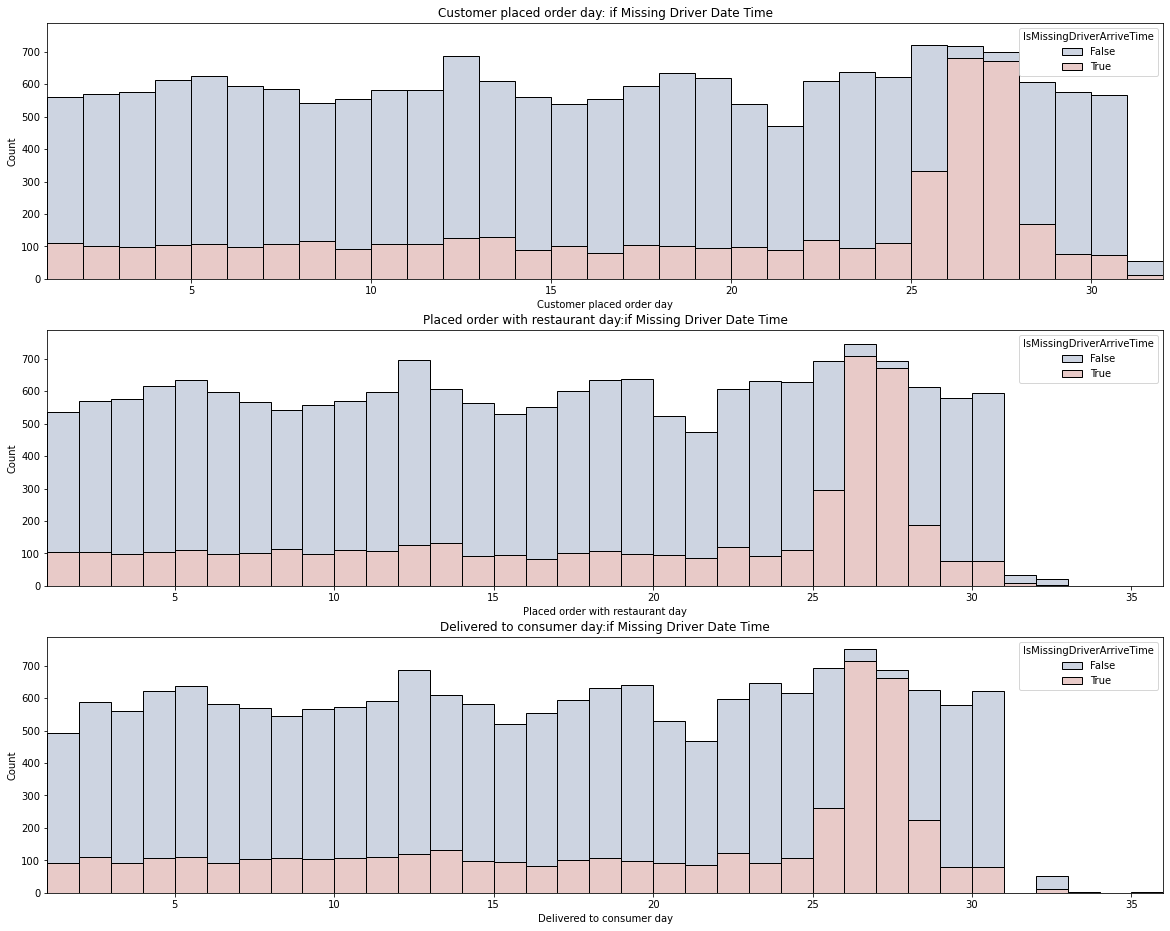

In [738]:
# define subplot size
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(20, 16))
bin_width=1
# plot graphs
sns.histplot(data_new6,x='Customer placed order day',hue='IsMissingDriverArriveTime',
             bins=order_width, binrange=(min_order, max_order+1),
             multiple='stack',palette='vlag',ax=ax1)

sns.histplot(data_new6,x='Placed order with restaurant day',hue='IsMissingDriverArriveTime',
             bins=place_width, binrange=(min_place, max_place+1),
             multiple='stack',palette='vlag',ax=ax2)

sns.histplot(data_new6,x='Delivered to consumer day',hue='IsMissingDriverArriveTime',
             bins=deliver_width, binrange=(min_deliver, max_deliver+1),
             multiple='stack',palette='vlag',ax=ax3)
# add title
ax1.set_title('Customer placed order day: if Missing Driver Date Time')
ax2.set_title('Placed order with restaurant day:if Missing Driver Date Time')
ax3.set_title('Delivered to consumer day:if Missing Driver Date Time')

# Define x-axis limits
ax1.set_xlim(min_order, max_order+1)
ax2.set_xlim(min_place, max_place+1)
ax3.set_xlim(min_deliver, max_deliver+1);


In [739]:
## Close look at the transaction ordered on Day 26 and 27---Missing value rate at 95% versus overall is 25%
print(data_new6[data_new6['Customer placed order day'].isin([26,27])]\
      ['IsMissingDriverArriveTime'].aggregate(['sum','count','mean']))
print(data_new6['IsMissingDriverArriveTime'].aggregate(['sum','count','mean']))
print(data_new6[data_new6['Customer placed order day'].isin([25,28])]\
      ['IsMissingDriverArriveTime'].aggregate(['sum','count','mean']))
print(data_new6[~data_new6['Customer placed order day'].isin([25,26,27,28])]\
      ['IsMissingDriverArriveTime'].aggregate(['sum','count','mean']))
#################################THOSE TWO DAY ARE ABNORMAL AND THE TREND SPREAD INTO DAY 25 AND 28 AS WELL
## so what have been changed from DAY25-28? Latter Day 25 and Begin 28? Parties Count? Avg Transaction size? 

sum      1352.000000
count    1419.000000
mean        0.952784
Name: IsMissingDriverArriveTime, dtype: float64
sum       4508.000000
count    18017.000000
mean         0.250208
Name: IsMissingDriverArriveTime, dtype: float64
sum       501.000000
count    1327.000000
mean        0.377543
Name: IsMissingDriverArriveTime, dtype: float64
sum       2655.000000
count    15271.000000
mean         0.173859
Name: IsMissingDriverArriveTime, dtype: float64


#### By Hours

In [740]:
def to_hour(datetime):
    return datetime.dt.seconds//3600

In [741]:
# Add New Features 
data_new7=data_new6
## hour columns of datetime

data_new7['Customer placed order hour']=to_hour(data_new7['Customer placed order datetime'])
data_new7['Placed order with restaurant hour']=to_hour(data_new7['Placed order with restaurant datetime_revised'])
data_new7['Driver at restaurant hour']=to_hour(data_new7['Driver at restaurant datetime_revised'])
data_new7['Delivered to consumer hour']=to_hour(data_new7['Delivered to consumer datetime_revised'])

data_new7.head()

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Driver at restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,IsMissingDriverArriveTime,IsMissingResPlaceTime,IsMissingDeliveryRegion,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour
0,1 days 02:52:12,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,True,1 days 03:00:25,1 days 03:08:09,1 days 03:35:20,1,1,1.0,1,True,False,False,False,2,3,3.0,3
1,13 days 15:58:57,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,True,13 days 17:56:45,13 days 18:24:39,13 days 18:57:01,13,13,13.0,13,True,False,False,False,15,17,18.0,18
2,17 days 19:02:37,212,190,12484,San Jose,True,16.77,6.0,2.52,0.0,True,17 days 19:12:51,17 days 19:19:59,17 days 19:31:09,17,17,17.0,17,True,False,False,False,19,19,19.0,19
3,12 days 04:01:57,352,194,13920,San Jose,True,25.03,0.0,5.00,0.0,True,12 days 04:08:18,12 days 04:13:02,12 days 04:37:57,12,12,12.0,12,True,False,False,False,4,4,4.0,4
4,8 days 23:46:38,313,9,7037,Palo Alto,True,51.57,0.0,5.16,0.0,True,8 days 23:49:32,8 days 23:54:29,9 days 00:37:15,8,8,8.0,9,False,False,False,False,23,23,23.0,0


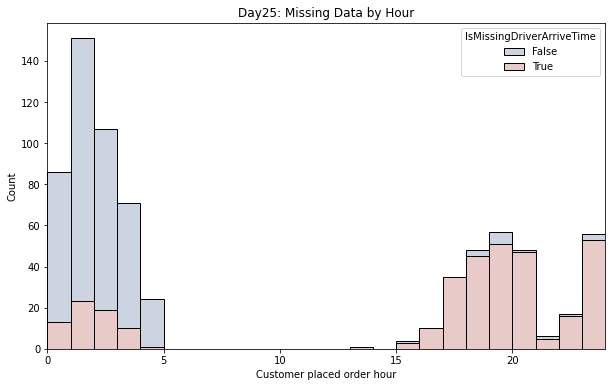

In [742]:
f, ax = plt.subplots(figsize=(10, 6)) 
sns.histplot(data_new7[data_new7['Customer placed order day']==25],
                       x='Customer placed order hour',hue='IsMissingDriverArriveTime',
             bins=24, 
             binrange=(0, 24),
             multiple='stack',palette='vlag')
plt.xlim(0, 24)
plt.title('Day25: Missing Data by Hour');
############### Day 25 Morning is normal

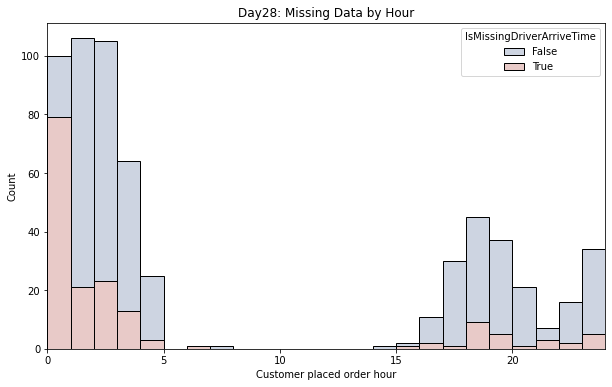

In [743]:
f, ax = plt.subplots(figsize=(10, 6)) 
sns.histplot(data_new7[data_new7['Customer placed order day']==28],
                       x='Customer placed order hour',hue='IsMissingDriverArriveTime',
             bins=24, 
             binrange=(0, 24),
             multiple='stack',palette='vlag')
plt.xlim(0, 24)
plt.title('Day28: Missing Data by Hour');
############### Abnormal Miss end Early Day 28- first hour
############### This clear time cut make me wonder if this is a technical issue in the backend---need further info 
###############  exclude while make it from reference group

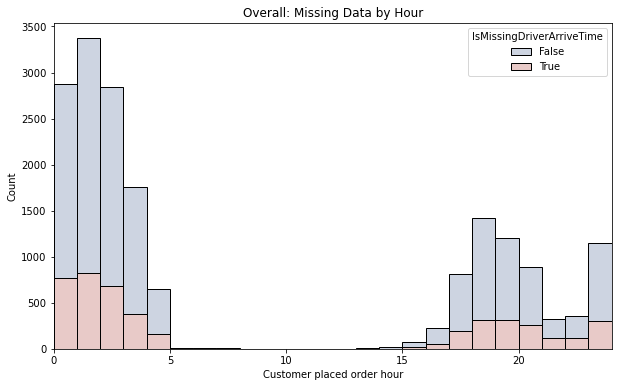

In [744]:
# Plot count by hour
f, ax = plt.subplots(figsize=(10, 6)) 
sns.histplot(data_new7,
                       x='Customer placed order hour',hue='IsMissingDriverArriveTime',
             bins=24, 
             binrange=(0, 24),
             multiple='stack',palette='vlag')
plt.xlim(0, 24)
plt.title('Overall: Missing Data by Hour');

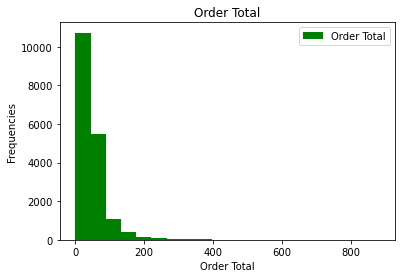

In [745]:
# plot Order total distribution
plt.hist(data_new7['Order total'], bins=20, facecolor='g', label='Order Total', orientation='vertical', align='mid') #vertical is default
plt.title("Order Total")
plt.xlabel("Order Total")
plt.ylabel("Frequencies")
plt.legend()

In [746]:
# Add new feature to fill in missing value
data_new8=data_new7
## TimeDiff_DriverArrival_CustomerOrder
data_new8['TimeDiff_DriverArrival_CustomerOrder']=\
data_new8['Driver at restaurant datetime_revised']-\
data_new8['Customer placed order datetime']
## hour group
data_new8['hour group']=np.where(data_new8['Customer placed order hour']<=5,\
                                                       "Early Busy Hours",\
                                                       np.where(data_new8['Customer placed order hour']>=18,\
                                                                "Late Busy Hours","Mid Slow Hours"))
## order total group
data_new8['Order total group']=np.where(data_new8['Order total']>200,\
                                        "200 Above Big Meal",\
                                        np.where(data_new8['Order total']>160,\
                                                 "160-200",\
                                                 np.where(data_new8['Order total']>120,\
                                                          "120-160",\
                                                          np.where(data_new8['Order total']>90,\
                                                                  "90-120",\
                                                                  np.where(data_new8['Order total']>60,\
                                                                          "60-90",\
                                                                          np.where(data_new8['Order total']>30,\
                                                                                  "30-60","30 Below Small Meal"))))))
data_new8.head(2)

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Driver at restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,IsMissingDriverArriveTime,IsMissingResPlaceTime,IsMissingDeliveryRegion,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour,TimeDiff_DriverArrival_CustomerOrder,hour group,Order total group
0,1 days 02:52:12,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,True,1 days 03:00:25,1 days 03:08:09,1 days 03:35:20,1,1,1.0,1,True,False,False,False,2,3,3.0,3,0 days 00:15:57,Early Busy Hours,30 Below Small Meal
1,13 days 15:58:57,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,True,13 days 17:56:45,13 days 18:24:39,13 days 18:57:01,13,13,13.0,13,True,False,False,False,15,17,18.0,18,0 days 02:25:42,Mid Slow Hours,60-90


In [747]:
data_new8['TimeDiff_DriverArrival_CustomerOrder'].describe()

count                        13509
mean     0 days 00:55:03.930564808
std      0 days 04:09:50.569093407
min                0 days 00:01:08
25%                0 days 00:12:57
50%                0 days 00:21:40
75%                0 days 00:38:48
max                4 days 05:47:41
Name: TimeDiff_DriverArrival_CustomerOrder, dtype: object

#### Build Missing Data Reference table to fill in the data

In [887]:
data_miss_ref=data_new8[~(data_new8['Customer placed order day'].isin([25,26,27,28]))\
                       &(data_new8['IsMissingDriverArriveTime']==False)\
                       ]
data_miss_ref.head(2)                 

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Driver at restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,IsMissingDriverArriveTime,IsMissingResPlaceTime,IsMissingDeliveryRegion,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour,TimeDiff_DriverArrival_CustomerOrder,hour group,Order total group
0,1 days 02:52:12,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,True,1 days 03:00:25,1 days 03:08:09,1 days 03:35:20,1,1,1.0,1,True,False,False,False,2,3,3.0,3,0 days 00:15:57,Early Busy Hours,30 Below Small Meal
1,13 days 15:58:57,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,True,13 days 17:56:45,13 days 18:24:39,13 days 18:57:01,13,13,13.0,13,True,False,False,False,15,17,18.0,18,0 days 02:25:42,Mid Slow Hours,60-90


In [889]:
df_MissReference=data_miss_ref.groupby(['hour group','Is ASAP','Delivery Region']).agg(
#     avg_time_diff_DriverArrival_CustomerOrder=('TimeDiff_DriverArrival_CustomerOrder', lambda x:(x.sum()/x.count())\
#                    (seconds=math.ceil(x.sum()/x.count()))\
#                    -timedelta(microseconds=(x.sum()/x.count()).microseconds)\
#                   ),
    mode_time_diff_DriverArrival_CustomerOrder=('TimeDiff_DriverArrival_CustomerOrder',mode),
    #sum_time_diff=('TimeDiff_DriverArrival_CustomerOrder',sum),
    #record_count=('TimeDiff_DriverArrival_CustomerOrder','count'),
    #max_time_diff=('TimeDiff_DriverArrival_CustomerOrder',max),
    #min_time_diff=('TimeDiff_DriverArrival_CustomerOrder',min) 
)
#.reset_index()
#df_MissReference['avg_time_diff']=df_MissReference['avg_time_diff']-df_MissReference['avg_time_diff'].dt.microseconds
df_MissReference

mode_time_diff_DriverArrival_CustomerOrder
hour group       Is ASAP Delivery Region                                           
Early Busy Hours False   Mountain View                              0 days 01:07:20
                         Palo Alto                                  0 days 00:37:33
                         San Jose                                   0 days 00:52:41
                 True    Mountain View                              0 days 00:36:11
                         Palo Alto                                  0 days 00:09:59
                         San Jose                                   0 days 00:13:24
Late Busy Hours  False   Mountain View                              0 days 00:42:49
                         Palo Alto                                  0 days 00:45:13
                         San Jose                                   0 days 01:14:10
                 True    Mountain View                              0 days 00:18:07
                         Palo Alto                                  0 days 00:09:52
                         San Jose                                   0 days 00:13:30
Mid Slow Hours   False   Mountain View                              0 days 01:25:03
                         Palo Alto                                  0 days 01:22:40
                         San Jose                                   0 days 00:55:58
                 True    Palo Alto                                  0 days 02:25:42

In [802]:
# join data_new with df_ref_table
data_clean=data_new8.join(df_MissReference,on=['hour group','Is ASAP','Delivery Region'])
# fill in missing value
data_clean['Driver at restaurant datetime_filled']=np.where(data_clean['Driver at restaurant datetime_revised'].isnull(),\
                                                          data_clean['Customer placed order datetime']\
                                                          +data_clean['mode_time_diff_DriverArrival_CustomerOrder'],\
                                                          data_clean['Driver at restaurant datetime_revised'])
data_clean['Driver at restaurant day']=data_clean['Driver at restaurant datetime_filled'].dt.days
data_clean['Driver at restaurant hour']=to_hour(data_clean['Driver at restaurant datetime_filled'])
data_clean['TimeDiff_DriverArrival_CustomerOrder']=\
data_clean['Driver at restaurant datetime_filled']-data_clean['Customer placed order datetime']
# drop original missing value columns
data_clean=data_clean.drop(['Driver at restaurant datetime_revised','mode_time_diff_DriverArrival_CustomerOrder',\
                           'IsMissingDriverArriveTime','IsMissingResPlaceTime','IsMissingDeliveryRegion'], axis=1)
#Data format
data_clean=data_clean.astype({'Driver ID':'object', 'Restaurant ID':'object', 'Consumer ID':'object','Is ASAP':'bool'})
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18017 entries, 0 to 18077
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Customer placed order datetime                 18017 non-null  timedelta64[ns]
 1   Driver ID                                      18017 non-null  object         
 2   Restaurant ID                                  18017 non-null  object         
 3   Consumer ID                                    18017 non-null  object         
 4   Delivery Region                                18017 non-null  object         
 5   Is ASAP                                        18017 non-null  bool           
 6   Order total                                    18017 non-null  float64        
 7   Amount of discount                             18017 non-null  float64        
 8   Amount of tip                                 

# Data Exploration and Visualization (EDA) 

### Transaction

In [803]:
# re-assign
data_analysis=data_clean
################ add KPI
## tip percentage= tip/order total
data_analysis['Percentage of tip']=(data_analysis['Amount of tip']/data_analysis['Order total'])\
.round(3)
#.astype(float).map("{:.2%}".format)
## refund percentage= refund/order total
data_analysis['Percentage of refund']=(data_analysis['Refunded amount']/data_analysis['Order total'])\
.round(3)
#.astype(float).map("{:.2%}".format)
data_analysis['Is Refund']=np.where(data_analysis['Refunded amount']>0,1,0).astype(bool)
################ add new feature
# time diff
data_analysis['TimeDiff_Delivered_CustomerOrder']=\
data_analysis['Delivered to consumer datetime_revised']-data_analysis['Customer placed order datetime']
data_analysis['TimeDiff_RestaurantPlace_CustomerOrder']=\
data_analysis['Placed order with restaurant datetime_revised']-data_analysis['Customer placed order datetime']
# time diff percentile rank (asscending)
data_analysis['PCT_RestaurantPlace_CustomerOrder']=\
data_analysis['TimeDiff_RestaurantPlace_CustomerOrder'].rank(ascending=True,pct=True).round(2)
data_analysis['PCT_DriverArrival_CustomerOrder']=\
data_analysis['TimeDiff_DriverArrival_CustomerOrder'].rank(ascending=True,pct=True).round(2)
data_analysis['PCT_Delivered_CustomerOrder']=\
data_analysis['TimeDiff_Delivered_CustomerOrder'].rank(ascending=True,pct=True).round(2)
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18017 entries, 0 to 18077
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   Customer placed order datetime                 18017 non-null  timedelta64[ns]
 1   Driver ID                                      18017 non-null  object         
 2   Restaurant ID                                  18017 non-null  object         
 3   Consumer ID                                    18017 non-null  object         
 4   Delivery Region                                18017 non-null  object         
 5   Is ASAP                                        18017 non-null  bool           
 6   Order total                                    18017 non-null  float64        
 7   Amount of discount                             18017 non-null  float64        
 8   Amount of tip                                 

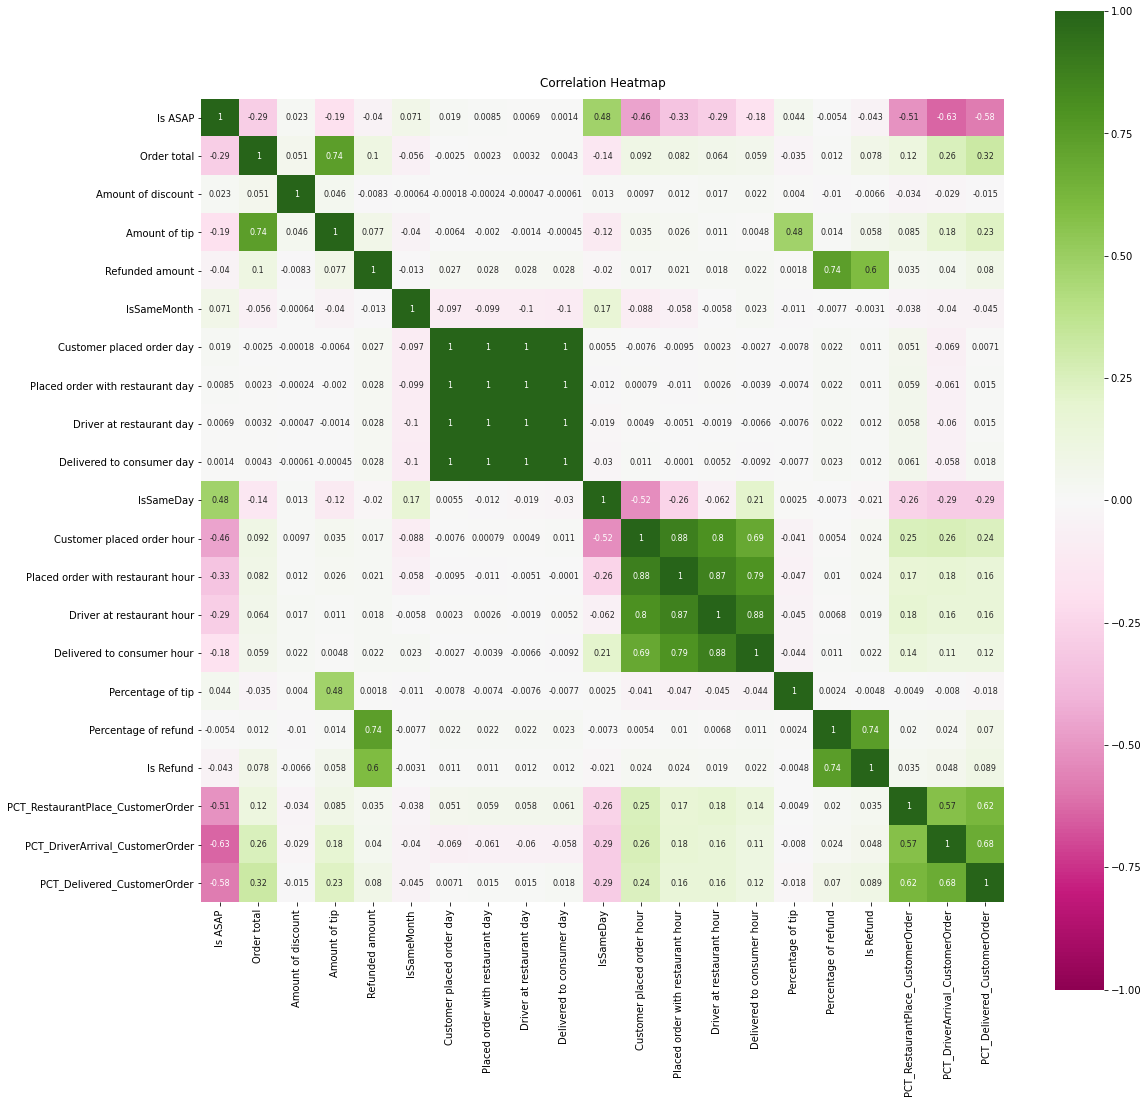

In [804]:
#correlation heatmap
plt.figure(figsize=(18,18))

heatmap = sns.heatmap(data_analysis.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

In [791]:
# Refund Analysis:491/18017=2.7%
data_refund=data_analysis[(data_analysis['Refunded amount']>0)&
                         (data_analysis['Order total']>0)]\
.sort_values('Percentage of refund',ascending=False)
data_refund.head(2)

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour,TimeDiff_DriverArrival_CustomerOrder,hour group,Order total group,Driver at restaurant datetime_filled,Percentage of tip,Percentage of refund,TimeDiff_Delivered_CustomerOrder,TimeDiff_RestaurantPlace_CustomerOrder,PCT_RestaurantPlace_CustomerOrder,PCT_DriverArrival_CustomerOrder,PCT_Delivered_CustomerOrder,Is Refund
14847,3 days 01:30:21,184,50,2611,Mountain View,True,31.5,0.0,6.00,37.50,True,3 days 01:33:32,3 days 01:54:21,3,3,3,3,True,1,1,1,1,0 days 00:11:20,Early Busy Hours,30-60,3 days 01:41:41,0.19,1.19,0 days 00:24:00,0 days 00:03:11,0.42,0.25,0.02,1
10961,20 days 03:16:09,264,158,12891,San Jose,True,22.8,0.0,3.42,26.22,True,20 days 03:16:58,20 days 04:49:12,20,20,20,20,True,3,3,3,4,0 days 00:30:31,Early Busy Hours,30 Below Small Meal,20 days 03:46:40,0.15,1.15,0 days 01:33:03,0 days 00:00:49,0.15,0.66,0.89,1


In [826]:
# If Scheduled/On Demand type is not from If refund perspective
contingency = pd.crosstab(data_analysis['Is Refund'],data_analysis['Is ASAP'])
stat, p, dof, expected = chi2_contingency(contingency)
#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Cannot Reject Dependency')
else:
    print('Independent')

p value is 1.3220624784945936e-08
Cannot Reject Dependency


In [845]:
# Total Waiting time from Customer Order to Delivery
pd.crosstab(data_analysis['Is ASAP'], data_analysis['Is Refund'], \
            data_analysis['PCT_Delivered_CustomerOrder'], aggfunc= 'median').round(3)

Is Refund,False,True
Is ASAP,,
False,0.89,0.925
True,0.40,0.570


In [876]:
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],92.5),'m'))
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],50),'m'))

109 minutes
48 minutes


In [852]:
data_analysis['TimeDiff_Delivered_CustomerOrder'].describe()

count                        18017
mean     0 days 01:19:51.325414885
std      0 days 04:03:40.016799662
min                0 days 00:00:28
25%                0 days 00:37:16
50%                0 days 00:48:16
75%                0 days 01:05:29
max                4 days 06:02:27
Name: TimeDiff_Delivered_CustomerOrder, dtype: object

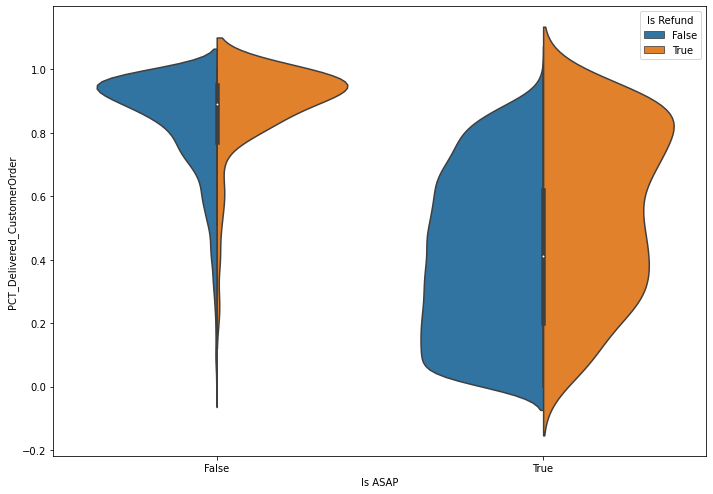

In [837]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
V1 = sns.violinplot(x="Is ASAP",y="PCT_Delivered_CustomerOrder",hue="Is Refund",data=data_analysis,split=True)
#########Scheduled delivery has higher refund risk when total delivery time fall below 92.5%---109min
#########On demand delivery has higher refund risk when total delivery time fall below 57%---48min

In [844]:
# Restaurant Place Order Time lag
pd.crosstab(data_analysis['Is ASAP'], data_analysis['Is Refund'], \
            data_analysis['PCT_RestaurantPlace_CustomerOrder'], aggfunc= 'median').round(3)

Is Refund,False,True
Is ASAP,,
False,0.89,0.905
True,0.42,0.440


In [877]:
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],90.5),'m'))
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],44),'m'))

98 minutes
45 minutes


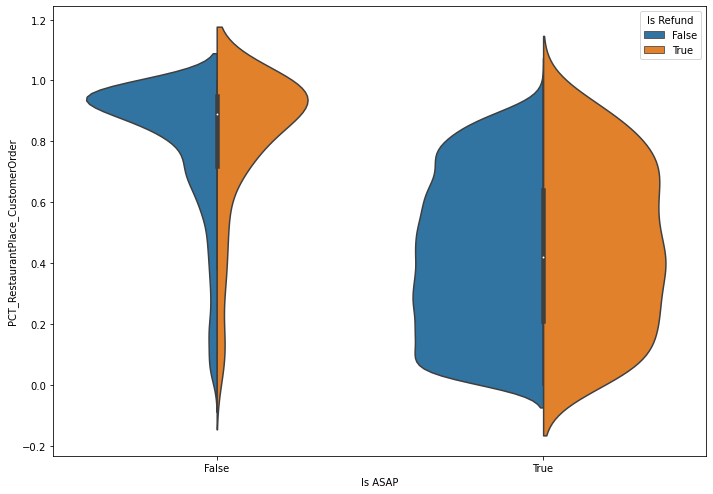

In [839]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
V1 = sns.violinplot(x="Is ASAP",y="PCT_RestaurantPlace_CustomerOrder",hue="Is Refund",data=data_analysis,split=True)
#########Scheduled delivery has higher refund risk when restaurant place order time lag fall below 90.5%---98min
#########On demand delivery has higher refund risk when restaurant place order time lag fall below 44%----45min

In [843]:
# Driver Arrival Time lag
pd.crosstab(data_analysis['Is ASAP'], data_analysis['Is Refund'], \
            data_analysis['PCT_DriverArrival_CustomerOrder'], aggfunc='median').round(3)

Is Refund,False,True
Is ASAP,,
False,0.89,0.92
True,0.40,0.45


In [878]:
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],92),'m'))
print(np.timedelta64(np.percentile(data_analysis['TimeDiff_Delivered_CustomerOrder'],45),'m'))

106 minutes
45 minutes


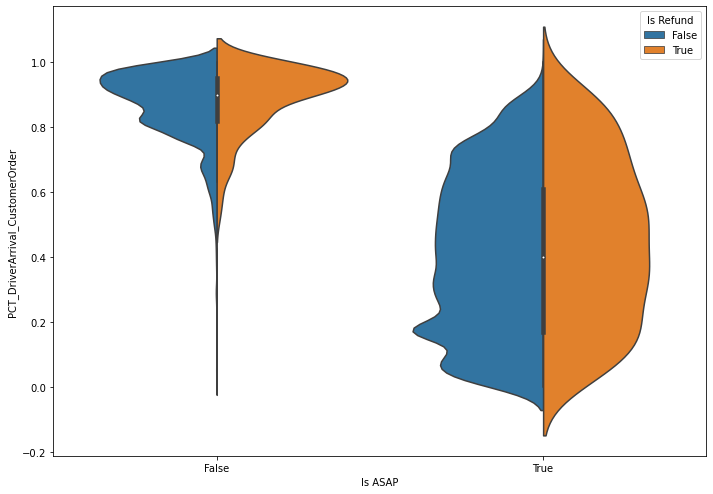

In [832]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
V1 = sns.violinplot(x="Is ASAP",y="PCT_DriverArrival_CustomerOrder",hue="Is Refund",data=data_analysis,split=True)
#########Scheduled delivery has higher refund risk when driver arrival restaurant time lag fall below 92%---106min
#########On demand delivery has higher refund risk when rdriver arrival restaurant time lag fall below 45%---45min

## Add New Feature to Analyze from different parties

In [942]:
# Re-assign
data_parties=data_analysis
## Add New KPIs
data_parties['Restuarant_refund_flag']=np.where((data_parties['Is ASAP']==False)&\
                                                (data_parties['TimeDiff_RestaurantPlace_CustomerOrder']>'0 days 01:36:00'),\
                                                1,\
                                                np.where((data_parties['Is ASAP']==True)&\
                                                         (data_parties['TimeDiff_RestaurantPlace_CustomerOrder']>'0 days 00:45:00'),\
                                                         1,0)).astype(bool)
data_parties['Driver_refund_flag']=np.where((data_parties['Is ASAP']==False)&\
                                                (data_parties['TimeDiff_DriverArrival_CustomerOrder']>'0 days 01:56:00'),\
                                                1,\
                                                np.where((data_parties['Is ASAP']==True)&\
                                                         (data_parties['TimeDiff_DriverArrival_CustomerOrder']>'0 days 00:45:00'),\
                                                         1,0)).astype(bool)
data_parties['Is Discount']=np.where(data_parties['Amount of discount']>0,1,0).astype(bool)
data_parties.head(2)

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour,TimeDiff_DriverArrival_CustomerOrder,hour group,Order total group,Driver at restaurant datetime_filled,Percentage of tip,Percentage of refund,Is Refund,TimeDiff_Delivered_CustomerOrder,TimeDiff_RestaurantPlace_CustomerOrder,PCT_RestaurantPlace_CustomerOrder,PCT_DriverArrival_CustomerOrder,PCT_Delivered_CustomerOrder,Restuarant_refund_flag,Driver_refund_flag,Is Discount
0,1 days 02:52:12,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,True,1 days 03:00:25,1 days 03:35:20,1,1,1,1,True,2,3,3,3,0 days 00:15:57,Early Busy Hours,30 Below Small Meal,1 days 03:08:09,0.050,0.0,False,0 days 00:43:08,0 days 00:08:13,0.62,0.42,0.39,False,False,False
1,13 days 15:58:57,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,True,13 days 17:56:45,13 days 18:57:01,13,13,13,13,True,15,17,18,18,0 days 02:25:42,Mid Slow Hours,60-90,13 days 18:24:39,0.085,0.0,False,0 days 02:58:04,0 days 01:57:48,0.96,0.97,0.97,True,True,False


### Driver

In [939]:
df_Driver=data_parties.groupby(['Driver ID']).agg(
    KPI_Driver_Refund_Flag_Percentage=('Driver_refund_flag',lambda x:x.sum()/x.count()),
    KPI_Avg_Tip_Percentage=('Percentage of tip', 'mean'),
    X_Count_Transaction=('Is ASAP','count'),
    X_Count_OnDemand_Percentage=('Is ASAP',lambda x:x.sum()/x.count()),
    X_Avg_OrderAmount=('Order total','mean'),
    X_mode_DriverArrival_lag=('TimeDiff_DriverArrival_CustomerOrder',mode),
    #X_mode_TotalDelivery_lag=('TimeDiff_Delivered_CustomerOrder',mode)
).reset_index().sort_values('KPI_Avg_Tip_Percentage',ascending=False)

df_Driver['X_PTC_mode_DriverArrival_lag']=\
df_Driver['X_mode_DriverArrival_lag'].rank(ascending=True,pct=True).round(2)

df_Driver['Driver ID']=df_Driver['Driver ID'].astype(str)

df_Driver

,Driver ID,KPI_Driver_Refund_Flag_Percentage,KPI_Avg_Tip_Percentage,X_Count_Transaction,X_Count_OnDemand_Percentage,X_Avg_OrderAmount,X_mode_DriverArrival_lag,X_PTC_mode_DriverArrival_lag
266,410,0.0,0.249500,2,0.5,38.900000,0 days 00:15:25,0.66
268,412,0.0,0.128800,5,0.8,43.034000,0 days 00:31:34,0.74
112,218,0.0,0.117667,6,1.0,37.443333,0 days 00:26:37,0.73
123,236,0.5,0.110500,2,1.0,44.000000,0 days 00:48:30,0.93
283,427,0.2,0.105500,10,0.8,41.579000,0 days 00:44:39,0.91
...,...,...,...,...,...,...,...,...
281,425,0.0,0.042333,9,1.0,51.570000,0 days 00:18:13,0.70
270,414,0.0,0.033500,2,1.0,23.345000,0 days 00:10:44,0.46
217,359,0.2,0.025000,5,0.8,31.470000,0 days 00:09:59,0.28
12,55,0.0,0.000000,1,0.0,21.700000,0 days 00:37:33,0.89


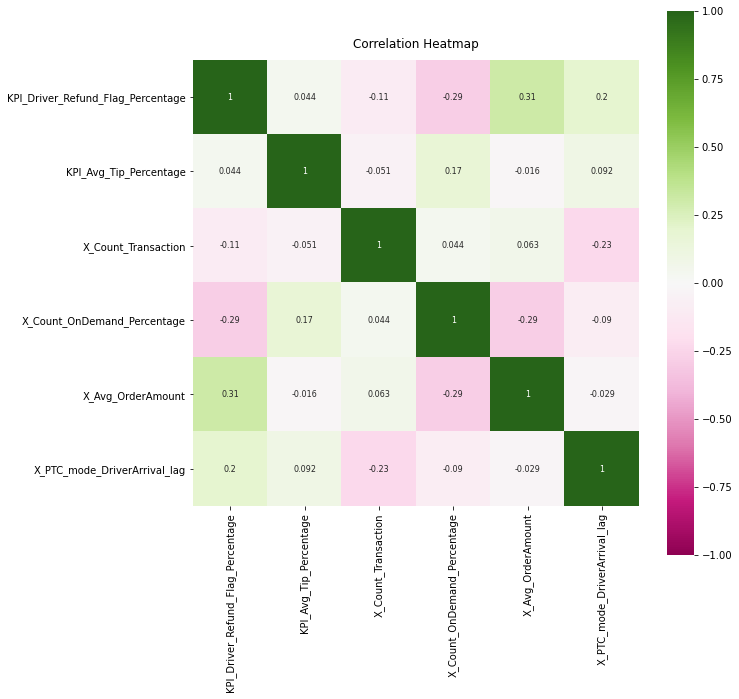

In [940]:
#correlation heatmap
plt.figure(figsize=(10,10))

heatmap = sns.heatmap(df_Driver.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

In [925]:
df_Driver['KPI_Avg_Tip_Percentage'].describe()

count    295.000000
mean       0.071225
std        0.016691
min        0.000000
25%        0.064933
50%        0.070036
75%        0.076401
max        0.249500
Name: KPI_Avg_Tip_Percentage, dtype: float64

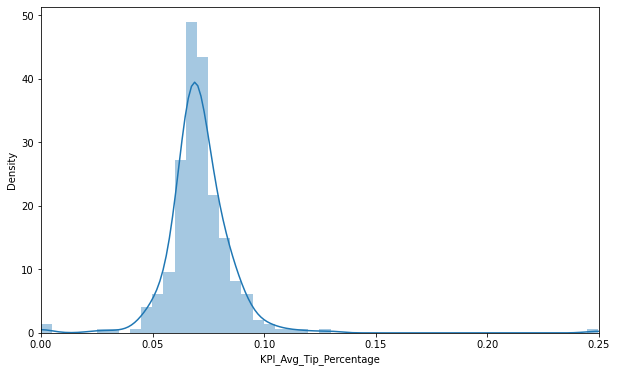

In [926]:
# KPI Distribution
f, ax = plt.subplots(figsize=(10, 6)) 
sns.distplot(df_Driver['KPI_Avg_Tip_Percentage'])
plt.xlim(0, 0.25);

### Restuarant

In [938]:
data_parties.head(2)

,Customer placed order datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,IsSameMonth,Placed order with restaurant datetime_revised,Delivered to consumer datetime_revised,Customer placed order day,Placed order with restaurant day,Driver at restaurant day,Delivered to consumer day,IsSameDay,Customer placed order hour,Placed order with restaurant hour,Driver at restaurant hour,Delivered to consumer hour,TimeDiff_DriverArrival_CustomerOrder,hour group,Order total group,Driver at restaurant datetime_filled,Percentage of tip,Percentage of refund,Is Refund,TimeDiff_Delivered_CustomerOrder,TimeDiff_RestaurantPlace_CustomerOrder,PCT_RestaurantPlace_CustomerOrder,PCT_DriverArrival_CustomerOrder,PCT_Delivered_CustomerOrder,Restuarant_refund_flag,Driver_refund_flag
0,1 days 02:52:12,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,True,1 days 03:00:25,1 days 03:35:20,1,1,1,1,True,2,3,3,3,0 days 00:15:57,Early Busy Hours,30 Below Small Meal,1 days 03:08:09,0.050,0.0,False,0 days 00:43:08,0 days 00:08:13,0.62,0.42,0.39,False,False
1,13 days 15:58:57,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,True,13 days 17:56:45,13 days 18:57:01,13,13,13,13,True,15,17,18,18,0 days 02:25:42,Mid Slow Hours,60-90,13 days 18:24:39,0.085,0.0,False,0 days 02:58:04,0 days 01:57:48,0.96,0.97,0.97,True,True


In [947]:
df_Restuarant=data_parties.groupby(['Restaurant ID']).agg(
    KPI_Restuarant_Refund_Flag_Percentage=('Restuarant_refund_flag',lambda x:x.sum()/x.count()),
    kPI_Avg_OrderAmount=('Order total','mean'),
    KPI_Count_Transaction=('Is ASAP','count'),
    X_mode_RestaurantPlace_lag=('TimeDiff_RestaurantPlace_CustomerOrder',mode),
    X_OnDemand_Percentage=('Is ASAP',lambda x:x.sum()/x.count()),
    X_discount_Percentage=('Is Discount',lambda x:x.sum()/x.count()),
).reset_index().sort_values('KPI_Restuarant_Refund_Flag_Percentage',ascending=False)

df_Restuarant['X_PTC_RestaurantPlace_lag']=\
df_Restuarant['X_mode_RestaurantPlace_lag'].rank(ascending=True,pct=True).round(2)

df_Restuarant['Restaurant ID']=df_Restuarant['Restaurant ID'].astype(str)

df_Restuarant

,Restaurant ID,KPI_Restuarant_Refund_Flag_Percentage,kPI_Avg_OrderAmount,KPI_Count_Transaction,X_mode_RestaurantPlace_lag,X_OnDemand_Percentage,X_discount_Percentage,X_PTC_RestaurantPlace_lag
312,409,1.000000,76.040000,1,0 days 01:06:14,1.000000,0.000000,0.96
311,408,1.000000,18.560000,2,0 days 00:45:54,1.000000,0.000000,0.95
263,333,0.666667,48.430000,3,0 days 02:12:29,0.333333,0.666667,0.99
123,163,0.666667,38.156667,3,0 days 20:48:37,0.333333,0.000000,1.00
309,401,0.500000,38.600000,2,0 days 00:00:55,0.500000,1.000000,0.22
...,...,...,...,...,...,...,...,...
108,142,0.000000,37.162500,8,0 days 00:05:53,0.875000,0.250000,0.65
218,279,0.000000,68.995714,7,0 days 00:02:56,1.000000,0.285714,0.48
107,140,0.000000,29.793462,26,0 days 00:09:22,0.846154,0.346154,0.73
105,138,0.000000,39.006000,10,0 days 00:18:43,0.800000,0.000000,0.82


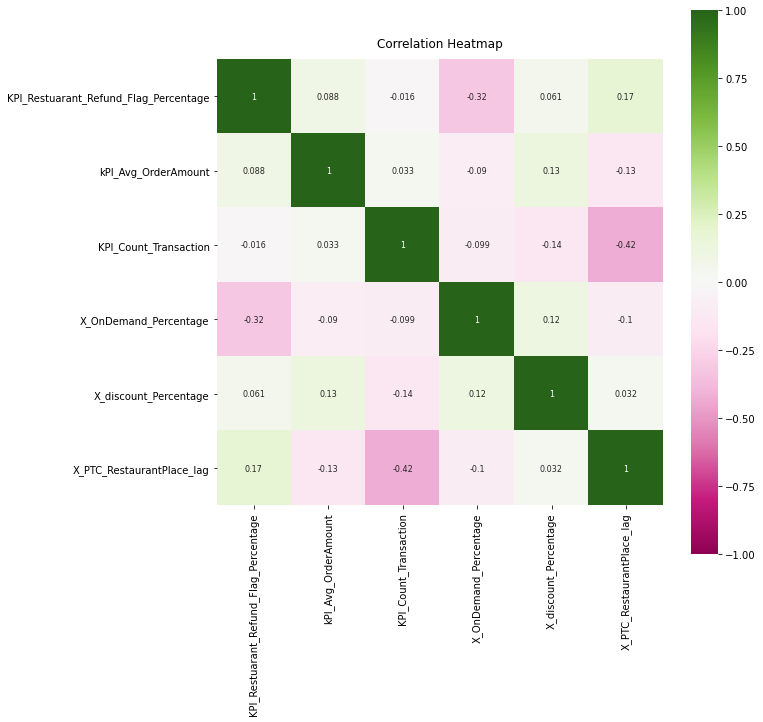

In [948]:
#correlation heatmap
plt.figure(figsize=(10,10))

heatmap = sns.heatmap(df_Restuarant.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

### Customer: 

In [954]:
df_Consumer=data_parties.groupby(['Consumer ID']).agg(
    KPI_Refund_Percentage=('Is Refund',lambda x:x.sum()/x.count()),
    kPI_Avg_OrderAmount=('Order total','mean'),
    kPI_Avg_TipPercentage=('Percentage of tip','mean'),
    KPI_Count_Transaction=('Is ASAP','count'),
    X_mode_order_hour=('Customer placed order hour',mode),
    X_unique_restaurant_count=('Restaurant ID',pd.Series.nunique),
    X_OnDemand_Percentage=('Is ASAP',lambda x:x.sum()/x.count()),
    X_discount_Percentage=('Is Discount',lambda x:x.sum()/x.count()),
).reset_index().sort_values('kPI_Avg_OrderAmount',ascending=False)

df_Consumer['Consumer ID']=df_Consumer['Consumer ID'].astype(str)

df_Consumer

,Consumer ID,KPI_Refund_Percentage,kPI_Avg_OrderAmount,kPI_Avg_TipPercentage,KPI_Count_Transaction,X_mode_order_hour,X_unique_restaurant_count,X_OnDemand_Percentage,X_discount_Percentage
1963,8007,0.0,696.6400,0.1355,2,19,2,0.0,0.5
5845,105568,0.0,585.9800,0.1350,1,1,1,0.0,1.0
1389,5403,0.0,506.0000,0.0590,1,6,1,0.0,0.0
3375,14495,0.0,483.9700,0.0000,1,23,1,0.0,0.0
1307,4983,0.0,472.1800,0.0450,1,19,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2006,8227,0.0,10.8225,0.0250,4,3,3,1.0,0.0
4695,76747,0.0,8.4200,0.0450,1,20,1,1.0,1.0
5145,86994,0.0,8.1600,0.0110,1,2,1,1.0,1.0
3509,18078,0.0,7.0100,0.0460,1,2,1,1.0,1.0


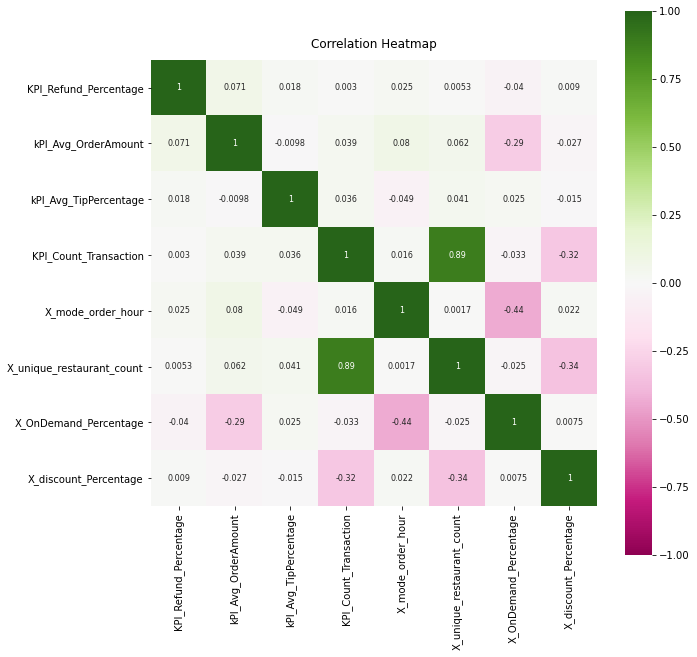

In [957]:
#correlation heatmap
plt.figure(figsize=(10,10))

heatmap = sns.heatmap(df_Consumer.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()